# Using `auto-sklearn` on the validation set to choose the best-suited model
- stripped-down version of `predict_task_failures.py`

In [3]:
import autosklearn.pipeline.components.data_preprocessing
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ConfigSpace.configuration_space import ConfigurationSpace
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.pipeline.components.base import AutoSklearnPreprocessingAlgorithm
from autosklearn.pipeline.constants import SPARSE, DENSE, UNSIGNED_DATA, INPUT
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.sql import SparkSession
from joblib import dump, load
from os.path import exists
import sklearn

### read the data from disk
- using Spark

In [2]:
appName = "auto-sklearn model selection"
spark = SparkSession\
    .builder\
    .appName(appName)\
    .master("local[3]")\
    .config("spark.driver.memory", "6g")\
    .getOrCreate()

22/03/05 20:05:08 WARN Utils: Your hostname, felix-Surface-Book resolves to a loopback address: 127.0.1.1; using 192.168.0.4 instead (on interface wlp3s0)
22/03/05 20:05:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/05 20:05:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# read dataset
data_name = "batch_jobs_clean_03inst_1task_00015S_1F"
data_path = f"../../out/clean/{data_name}/*.csv.gz"
data = spark.read.csv(data_path, header=True, inferSchema=True)
# reproduce training set
seed = 777
fractions = {0: 0.50, 1: 0.50}
training = data.sampleBy(col="labels", fractions=fractions, seed=seed)
# stratified (50/25/25) split to have 50% of the data for training, 25 for validation (hyper
rest = data.subtract(training)
fractions = {0: 0.25, 1: 0.25}
validation = rest.sampleBy(col = "labels", fractions = fractions, seed = seed)
test = rest.subtract(validation)
validation

DataFrame[task_name: string, job_name: string, task_id_num: int, instance_num: int, task_type: int, status: string, start_time: int, end_time: int, plan_cpu: double, plan_mem: double, map_reduce: string, earliest: int, sched_intv: int, job_exec: int, logical_job_name: string, latest: int, task_duration: int, tts_task: int, mtts_task: double, ttf_task: int, ttr_task: int, reduce_checkpoint: int, second_quant_checkpoint: int, third_quant_checkpoint: int, instance_name: string, instance_task_type: int, instance_status: string, instance_start_time: int, instance_end_time: int, machine_id: string, seq_no: int, total_seq_no: int, cpu_avg: double, cpu_max: double, mem_avg: double, mem_max: double, labels: int]

### read the model from disk

In [4]:
model_name = "GBT5CV3parall_priorFeat_tune_maxDepth_Iter_Bins_03inst777Seed"
model_path = f"../../out/model/dump/final/{model_name}"
# load CV model and get the pipeline
cv_model = CrossValidatorModel.load(model_path)

In [5]:
seed=777

In [6]:
cv_model.bestModel.stages

[StringIndexerModel: uid=strIdx_8f882ce3e7f2, handleInvalid=skip, numInputCols=2, numOutputCols=2,
 OneHotEncoderModel: uid=oneHotEncoder_4163c0bb0e65, dropLast=true, handleInvalid=error, numInputCols=2, numOutputCols=2,
 ImputerModel: uid=imputer_0595fa77a18a, strategy=mean, missingValue=NaN, numInputCols=7, numOutputCols=7,
 vecAssembler_32249f5d0828,
 MinMaxScalerModel: uid=minMaxScal_1ef6614d0656, numFeatures=1, min=0.0, max=1.0,
 vecAssembler_6a76b76d599f,
 GBTClassificationModel: uid = gbtc_a91cd4e7d994, numTrees=5, numClasses=2, numFeatures=2175]

### transform the validation data

In [7]:
# taken from GBTCVTaskFailBinPred.scala
columns = ["instance_num",  # number of instances for the task
           "task_type",  # values 1-12, meaning unknown (ordinal categ. feature)
           "plan_cpu",  # number of cpus needed by the task, 100 is 1 core
           "plan_mem",  # normalized memory size, [0, 100]
           # from batch instances
           "seq_no",
           "labels",
           # custom fields I added in trace.py
           "map_reduce",
           # whether this task is a map "m" or reduce "r" operation (nominal categ. feature) -> 1hot encode
           "sched_intv",  # the schedule interval (in ?) if this value is set, its a recurring job (batch job)
           "job_exec",  # the number of execution of this task
           "logical_job_name"]
# get only raw features for transform
validation_raw = validation.select(columns)

In [8]:
fractions = {0: 0.50, 1: 0.50}
val_raw_lim = validation_raw.sampleBy(col="labels", fractions=fractions, seed=seed)

In [9]:
# transform the validation data
validation_transf = cv_model.bestModel.transform(val_raw_lim)\
    .toPandas()
validation_transf = validation_transf[["features", "labels"]]

22/03/05 20:05:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/03/05 20:06:01 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/03/05 20:06:01 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [10]:
spark.stop()

### Convert `pandas` SparseVector to `NumPy` Array
- adapted from [this tutorial](http://blog.madhukaraphatak.com/spark-vector-to-numpy/)

In [11]:
series = validation_transf['features'].apply(lambda x : np.array(x.toArray())).to_numpy().reshape(-1,1)
X_val = np.apply_along_axis(lambda x : x[0], 1, series)
X_val.shape

(46380, 2175)

In [12]:
y_val = validation_transf["labels"].to_numpy()
y_val.shape

(46380,)

## Train models

### using sklearn

### split the validation set into train and test

In [13]:
from sklearn.model_selection import train_test_split
X_train_skl, X_test_skl, y_train_skl, y_test_skl = train_test_split(
    X_val, y_val, test_size=0.20, random_state=seed)

### define, train and predict the interpretable models

In [14]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
# define
rf = RandomForestClassifier(max_depth=2, random_state=seed)
gbt = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0)
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
svm = svm.SVC()
gnb = GaussianNB()

clfs = {"RF" :rf, "GBT":gbt, "MLP":mlp, "SVM":svm, "GNB":gnb}

In [15]:
preds = {}
for name, clf in clfs.items():
    clf.fit(X_train_skl, y_train_skl)
    y_pred = clf.predict(X_test_skl)
    preds[name] = y_pred
preds

{'RF': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'GBT': array([1, 1, 1, ..., 1, 1, 0], dtype=int32),
 'MLP': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'SVM': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'GNB': array([1, 1, 1, ..., 0, 1, 0], dtype=int32)}

### calculate tpr, fpr, auc for each model

In [16]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each model
rates = {}
for name, y_pred in preds.items():
    fpr, tpr, _ = roc_curve(y_test_skl, y_pred)
    roc_auc = auc(fpr, tpr)
    rates[name] = {"fpr": fpr, "tpr": tpr, "roc_auc": roc_auc}
rates

{'RF': {'fpr': array([0.        , 0.78529203, 1.        ]),
  'tpr': array([0.        , 0.97404399, 1.        ]),
  'roc_auc': 0.5943759776567984},
 'GBT': {'fpr': array([0.        , 0.09836841, 1.        ]),
  'tpr': array([0.        , 0.87497523, 1.        ]),
  'roc_auc': 0.8883034121021678},
 'MLP': {'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'roc_auc': 0.5},
 'SVM': {'fpr': array([0.        , 0.39512887, 1.        ]),
  'tpr': array([0.        , 0.73647712, 1.        ]),
  'roc_auc': 0.6706741215220577},
 'GNB': {'fpr': array([0.        , 0.13596595, 1.        ]),
  'tpr': array([0.        , 0.53893402, 1.        ]),
  'roc_auc': 0.7014840354065027}}

In [2]:
# hardcoded rates to alleviate me from retraining
rates = {'RF': {'fpr': [0.        , 0.78529203, 1.        ],
  'tpr': [0.        , 0.97404399, 1.        ],
  'roc_auc': 0.5943759776567984},
 'GBT': {'fpr': [0.        , 0.09836841, 1.        ],
  'tpr': [0.        , 0.87497523, 1.        ],
  'roc_auc': 0.8883034121021678},
 'MLP': {'fpr': [0., 1.], 'tpr': [0., 1.], 'roc_auc': 0.5},
 'SVM': {'fpr': [0.        , 0.39512887, 1.        ],
  'tpr': [0.        , 0.73647712, 1.        ],
  'roc_auc': 0.6706741215220577},
 'GNB': {'fpr': [0.        , 0.13596595, 1.        ],
  'tpr': [0.        , 0.53893402, 1.        ],
  'roc_auc': 0.7014840354065027}}

### plot ROC curves for each model

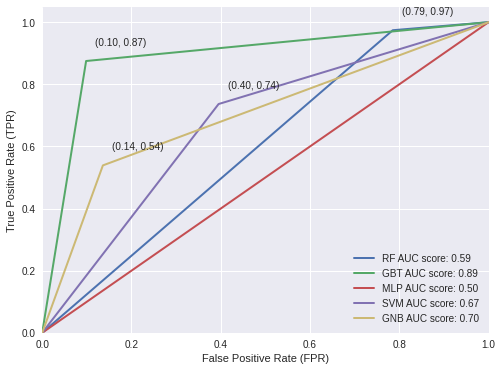

In [10]:
mpl.style.use("seaborn")
plt.figure(figsize=(8,6))
lw = 2
# the roc curves
for name, rate in rates.items():

    plt.plot(
        rate["fpr"],
        rate["tpr"],
        lw=lw,
        label=f"{name} AUC score: %0.2f" % rate["roc_auc"],
    )
    # show point coordinates
    for i, j in zip(rate["fpr"], rate["tpr"]):
        if i and j not in [0.00, 1.0]:
            plt.text(i+0.02, j+0.05, '({0:.2f}, {1:.2f})'.format(i, j))
# the diagonal line
#plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
#plt.title("Receiver operating characteristic (ROC) curve")
plt.legend(loc="lower right")
plt.savefig(f"../../out/analysis/model/algoSelectROCCurves.pdf", format="pdf")
plt.show()

### using autosklearn

### define hyperparameters

In [13]:
hyper_params = {
    "task_time_lim": 1800,  # in seconds
    #"time_left_for_this_task": 3600 * 24,  # one day in seconds (auto-sklearn suggestion)
    "run_time_lim": 180,  # 30 minutes in seconds
    #"run_time_lim": 1800,  # 30 minutes in seconds (auto-sklearn suggestion)
    "mem_lim": 3072,
    "clfs": [
        #"liblinear_svc",  # LinearSVC in MLlib"
        "libsvm_svc",  # LinearSVC in MLlib
        "gradient_boosting",  # GBTClasifier in MLlib
        "random_forest",  # RandomForestClassifier in MLlib
        "multinomial_nb",  # NaiveBayes in MLlib
        #"bernoulli_nb",  # NaiveBayes in MLlib"
        "mlp"  # MultiLayerPerceptron in MLlib
    ],
    "nbest": 10,
    #"resampling_strategy": "cv",
    "res_strat": "holdout",
    "res_strat_args": {"train_size": 0.80},
    #"resampling_strategy_arguments": {"folds": 5},
    "n_jobs": 1,
    "seed": seed
}

In [14]:
class NoPreprocessing(AutoSklearnPreprocessingAlgorithm):

    def __init__(self, **kwargs):
        """ This preprocessors does not change the data """
        # Some internal checks makes sure parameters are set
        for key, val in kwargs.items():
            setattr(self, key, val)

    def fit(self, X, Y=None):
        return self

    def transform(self, X):
        return X

    @staticmethod
    def get_properties(dataset_properties=None):
        return {
            "shortname": "NoPreprocessing",
            "name": "NoPreprocessing",
            "handles_regression": True,
            "handles_classification": True,
            "handles_multiclass": True,
            "handles_multilabel": True,
            "handles_multioutput": True,
            "is_deterministic": True,
            "input": (SPARSE, DENSE, UNSIGNED_DATA),
            "output": (INPUT,)
        }

    @staticmethod
    def get_hyperparameter_search_space(dataset_properties=None):
        return ConfigurationSpace()  # Return an empty configuration as there is None


# Add NoPreprocessing component to auto-sklearn.
autosklearn.pipeline.components.data_preprocessing.add_preprocessor(NoPreprocessing)

In [15]:
# cast the hyper parameter values to string
string_params = [str(p) for p in hyper_params.values()]
# combine the hyper string keys and the hyper string params to a list of tuples
hyper_params_str = list(zip(hyper_params.keys(), string_params))
# concat the values of each tuple with with "-"
hyper_params_str_pairs = ["-".join(tup) for tup in hyper_params_str]
# concat all key-value strings to get the final name
automl_name = "-".join(hyper_params_str_pairs)
automl_name

"task_time_lim-1800-run_time_lim-180-mem_lim-3072-clfs-['libsvm_svc', 'gradient_boosting', 'random_forest', 'multinomial_nb', 'mlp']-nbest-10-res_strat-holdout-res_strat_args-{'train_size': 0.8}-n_jobs-1-seed-777"

In [16]:
dataset_name = "batch_jobs_clean_03inst_1task_00015S_1FVal"
#dataset_name = "breast_cancer"

In [17]:
clf = AutoSklearnClassifier(
    time_left_for_this_task=hyper_params["task_time_lim"],
    per_run_time_limit=hyper_params["run_time_lim"],
    memory_limit=hyper_params["mem_lim"],
    include={"classifier": hyper_params["clfs"],
             "feature_preprocessor": ["no_preprocessing"],
             "data_preprocessor": ["NoPreprocessing"],
             },
    exclude=None,
    ensemble_nbest=hyper_params["nbest"],
    resampling_strategy=hyper_params["res_strat"],
    resampling_strategy_arguments=hyper_params["res_strat_args"],
    n_jobs=hyper_params["n_jobs"],
    seed=hyper_params["seed"]
)

### train and persist or load the model

In [18]:
path = f"../../out/model/dump/auto-sklearn/{dataset_name}.joblib"
if exists(path):
    print("loading the model")
    clf = load(path)
else:
    print("fit and persist the model")
    clf.fit(X_val, y_val, dataset_name=dataset_name)
    dump(clf, path)

fit and persist the model
[WARNING] [2022-01-30 14:53:39,482:Client-AutoMLSMBO(777)::batch_jobs_clean_03inst_1task_00015S_1FVal] Configuration 536 not found
[WARNING] [2022-01-30 14:53:39,482:Client-AutoMLSMBO(777)::batch_jobs_clean_03inst_1task_00015S_1FVal] Configuration 145 not found
[WARNING] [2022-01-30 14:53:39,482:Client-AutoMLSMBO(777)::batch_jobs_clean_03inst_1task_00015S_1FVal] Configuration 393 not found
[WARNING] [2022-01-30 14:53:39,482:Client-AutoMLSMBO(777)::batch_jobs_clean_03inst_1task_00015S_1FVal] Configuration 81 not found
[WARNING] [2022-01-30 14:53:39,482:Client-AutoMLSMBO(777)::batch_jobs_clean_03inst_1task_00015S_1FVal] Configuration 690 not found
[WARNING] [2022-01-30 14:53:39,482:Client-AutoMLSMBO(777)::batch_jobs_clean_03inst_1task_00015S_1FVal] Configuration 9 not found
[WARNING] [2022-01-30 14:53:39,482:Client-AutoMLSMBO(777)::batch_jobs_clean_03inst_1task_00015S_1FVal] Configuration 114 not found
[WARNING] [2022-01-30 14:53:39,482:Client-AutoMLSMBO(777)::b

## Inspect the results

In [19]:
# basic statistics
clf.sprint_statistics()

'auto-sklearn results:\n  Dataset name: batch_jobs_clean_03inst_1task_00015S_1FVal\n  Metric: accuracy\n  Best validation score: 0.933555\n  Number of target algorithm runs: 42\n  Number of successful target algorithm runs: 39\n  Number of crashed target algorithm runs: 0\n  Number of target algorithms that exceeded the time limit: 3\n  Number of target algorithms that exceeded the memory limit: 0\n'

In [20]:
# evaluated models
clf.show_models()

{39: {'model_id': 39,
  'rank': 1,
  'cost': 0.06644518272425248,
  'ensemble_weight': 0.16,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f82849039a0>,
  'balancing': Balancing(random_state=777, strategy='weighting'),
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7f8284903c40>,
  'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7f82849034c0>,
  'sklearn_classifier': RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=792,
                         min_samples_leaf=2, min_samples_split=6,
                         n_estimators=512, n_jobs=1, random_state=777,
                         warm_start=True)},
 2: {'model_id': 2,
  'rank': 2,
  'cost': 0.06727574750830567,
  'ensemble_weight': 0.06,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f82be9da820>,
  

In [21]:
leaderboard = clf.leaderboard()
leaderboard

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
39,1,0.16,random_forest,0.066445,77.225176
2,2,0.06,random_forest,0.067276,25.115608
37,3,0.06,random_forest,0.067276,24.354770
35,4,0.04,random_forest,0.068937,24.792944
31,5,0.40,random_forest,0.072259,42.893292
20,6,0.08,random_forest,0.073090,60.828630
18,7,0.20,random_forest,0.075581,86.058677


In [22]:
cv_results = pd.DataFrame.from_dict(clf.cv_results_)
cv_results

,mean_test_score,mean_fit_time,params,rank_test_scores,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,...,param_classifier:random_forest:max_leaf_nodes,param_classifier:random_forest:min_impurity_decrease,param_classifier:random_forest:min_samples_leaf,param_classifier:random_forest:min_samples_split,param_classifier:random_forest:min_weight_fraction_leaf,param_classifier:gradient_boosting:n_iter_no_change,param_classifier:gradient_boosting:validation_fraction,param_classifier:libsvm_svc:coef0,param_classifier:libsvm_svc:degree,param_classifier:mlp:validation_fraction
0,0.932724,25.115608,"{'balancing:strategy': 'none', 'classifier:__c...",2,Success,0.0,none,random_forest,NoPreprocessing,no_preprocessing,...,None,0.0,1.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
1,0.911960,106.581963,"{'balancing:strategy': 'none', 'classifier:__c...",15,Success,0.0,none,gradient_boosting,NoPreprocessing,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN
2,0.904485,47.432646,"{'balancing:strategy': 'weighting', 'classifie...",17,Success,0.0,weighting,libsvm_svc,NoPreprocessing,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.534884,27.872614,"{'balancing:strategy': 'none', 'classifier:__c...",37,Success,0.0,none,libsvm_svc,NoPreprocessing,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.868982,5.0,NaN
4,0.460133,3.765672,"{'balancing:strategy': 'weighting', 'classifie...",39,Success,0.0,weighting,mlp,NoPreprocessing,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.911960,92.788919,"{'balancing:strategy': 'weighting', 'classifie...",15,Success,0.0,weighting,random_forest,NoPreprocessing,no_preprocessing,...,None,0.0,8.0,14.0,0.0,NaN,NaN,NaN,NaN,NaN
6,0.535714,14.508767,"{'balancing:strategy': 'weighting', 'classifie...",36,Success,0.0,weighting,mlp,NoPreprocessing,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.000000,180.028585,"{'balancing:strategy': 'weighting', 'classifie...",40,Timeout,0.0,weighting,gradient_boosting,NoPreprocessing,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
8,0.823090,28.492512,"{'balancing:strategy': 'none', 'classifier:__c...",29,Success,0.0,none,gradient_boosting,NoPreprocessing,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN
9,0.539867,60.013170,"{'balancing:strategy': 'weighting', 'classifie...",34,Success,0.0,weighting,libsvm_svc,NoPreprocessing,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.709730,NaN,NaN


In [23]:
mpl.style.use("seaborn")

<Figure size 576x432 with 0 Axes>

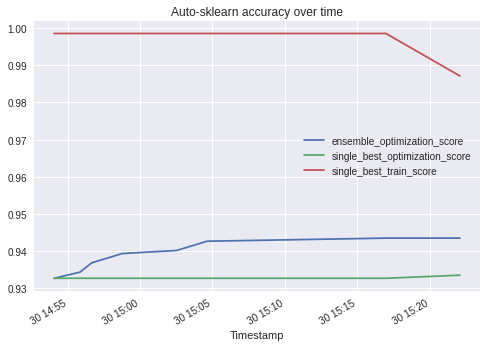

In [24]:
plt.figure(figsize=(8, 6))

perf_plot = clf.performance_over_time_.plot(
    x="Timestamp",
    kind="line",
    legend=True,
    title="Auto-sklearn accuracy over time",
    grid=True,
)
filename = f"../../out/model/plots/auto-sklearn/performance/{dataset_name}.pdf"
plt.savefig(filename)